# Part 1 - WeatherPy

In this exercise, I will look at global weather data to see if we can identify trends in key measurements in temperature, humidity, cloudiness, and wind speed. To do this, I will use weather data pulled from [Open Weather Map's API](https://openweathermap.org/api) and city locations from the Python library [Citipy](https://pypi.org/project/citipy/). I will chart each of these metrics to show visual data trends, and then perform linear regressions to show how closely weather correlates to Earth's latitude.

## Collect Data:

In [1]:
# Import dependencies:

import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from config import api_key
import time   #used for time.sleep

In [2]:
# Generate a random list of 500 unique cities with a reasonably even distribution across the globe

# Set a range for lat and lng that includes the whole Earth
# latitude range is -90 to 90, longitude range is -180 to 180
lats = []
longs = []

lats = np.random.uniform(-90, 90, 1500)
longs = np.random.uniform(-180, 180, 1500)

#print(lats)
#print(longs)

In [3]:
# zip lists together to form coordinates
lat_long = zip(lats, longs)

In [4]:
# Use citipy to find cities near coordinates

#Import citipy
from citipy import citipy

cities = []
countries = []

for lat_long in lat_long:
    city = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm sufficient count
print(len(cities))
print(len(countries))

614
614


In [5]:
# Format data for improved legibility
cities = [city.title() for city in cities]
countries = [country.upper() for country in countries]

In [6]:
# Build dataframe to hold data
weather_df = pd.DataFrame({"Cities" : cities, "Countries" : countries})
weather_df.head()

,Cities,Countries
0,Vuktyl,RU
1,Codrington,AG
2,Busselton,AU
3,Provideniya,RU
4,Boyolangu,ID


In [7]:
# Check for NaNs
weather_df.isnull().sum()

Cities       0
Countries    0
dtype: int64

In [8]:
# Add places to hold data for each city

weather_df["Latitude"] = ""
weather_df["Longitude"] = ""
weather_df["Max Temperature (F)"] = ""
weather_df["Humidity (%)"] = ""
weather_df["Cloudiness"] = ""
weather_df["Wind Speed (mph)"] = ""
weather_df["Date"] = ""
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Vuktyl,RU,,,,,,,
1,Codrington,AG,,,,,,,
2,Busselton,AU,,,,,,,
3,Provideniya,RU,,,,,,,
4,Boyolangu,ID,,,,,,,


In [9]:
# Use OpenWeather to get weather data for generated list of cities, test on one city

base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = "Minneapolis"
country_code = "US"
query_url = f"{base_url}q={city_name},{country_code}&appid={api_key}&units=imperial"
#print(query_url) - test url worked
#minneapolis_weather = requests.get(query_url).json()
#minneapolis_weather

In [10]:
# Build a for loop to use the city names to call the OpenWeather API
# Test to ensure that the city has data, otherwise skip
# Generate a print log for each city as it is being processed

my_params = {"appid" : api_key, "units" : "imperial"}

for index, row in weather_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row["Cities"]
    country = row["Countries"]
    
    my_params['q'] = f'{city},{country}'
    
    #make request
    cities_weather = requests.get(base_url, params=my_params).json()
    print(index, city)
    try:
        weather_df.loc[index, "Latitude"] = cities_weather["coord"]["lat"]
    except KeyError:
        weather_df.loc[index, "Latitude"] = np.nan
        print("skip")
        continue
       
    weather_df.loc[index, "Longitude"] = cities_weather["coord"]["lon"]
    weather_df.loc[index, "Max Temperature (F)"] = cities_weather["main"]["temp_max"]
    weather_df.loc[index, "Humidity (%)"] = cities_weather["main"]["humidity"]
    weather_df.loc[index, "Cloudiness"] = cities_weather["clouds"]["all"]
    weather_df.loc[index, "Wind Speed (mph)"] = cities_weather["wind"]["speed"]
    weather_df.loc[index, "Date"] = cities_weather["dt"]
    
    time.sleep(1)
        

0 Vuktyl
1 Codrington
skip
2 Busselton
3 Provideniya
4 Boyolangu
5 Honiara
6 Kaspican
skip
7 Rikitea
8 Charters Towers
9 Hilo
10 Tamiahua
11 Kawalu
12 Cape Town
13 Quatre Cocos
14 Cabo San Lucas
15 Dikson
16 Punta Arenas
17 Tasiilaq
18 Hobart
19 Bluff
20 Pastos Bons
21 Arkadelphia
22 Ushuaia
23 Saint-Ambroise
24 Khatanga
25 Kapaa
26 Hirara
27 Tuktoyaktuk
28 Clyde River
29 Palauig
30 At-Bashi
31 Port Alfred
32 Bredasdorp
33 Jamestown
34 Mogzon
35 Teguldet
36 Mahebourg
37 Avarua
38 Hermanus
39 Tara
40 Kavieng
41 Owando
42 Atuona
43 Saldanha
44 Butaritari
45 Isangel
46 Karratha
47 Anadyr
48 Taolanaro
skip
49 Itaituba
50 Tabiauea
skip
51 Narsaq
52 Bethel
53 Domoni
54 Sorvag
skip
55 Charleville-Mezieres
56 Zirandaro
57 Antofagasta
58 Trelew
59 Huaicheng
60 Kamenskoye
skip
61 New Norfolk
62 Chokurdakh
63 Am Timan
64 Meiktila
65 Qaanaaq
66 Torbay
67 Pombia
68 Tumannyy
skip
69 Tiksi
70 Barentsburg
skip
71 Laguna
72 Mataura
skip
73 Chornobayivka
74 Gazanjyk
75 Price
76 Carnarvon
77 Nikolskoye
7

594 San Cristobal
595 Kerki
skip
596 Sukabumi
597 Pathein
598 North Bend
599 Mikhaylovka
600 Verkhoyansk
601 Rawannawi
skip
602 Demak
603 Noumea
604 Volzhskiy
605 Sibolga
606 Japura
skip
607 Pullman
608 Macau
609 Maiduguri
610 Kurayoshi
611 Lichinga
612 Port Keats
613 Palabuhanratu
skip


In [11]:
#Drop rows with missing values
weather_df.dropna(inplace=True)
weather_df.reset_index(drop=True, inplace=True)
len(weather_df)

545

In [12]:
# Check for humidity outliers
weather_df["Humidity (%)"].max()

100

In [13]:
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Vuktyl,RU,63.8567,57.3094,-19.26,88,93,1.63,1612896970
1,Busselton,AU,-33.65,115.333,55,97,90,6.78,1612896971
2,Provideniya,RU,64.3833,-173.3,-5.31,77,0,13.94,1612896177
3,Boyolangu,ID,-8.1181,111.894,75.54,88,93,2.21,1612896632
4,Honiara,SB,-9.4333,159.95,78.64,82,30,6.2,1612896722


In [14]:
#Clean up formatting
weather_df = weather_df.convert_dtypes()
weather_df = weather_df.round({"Latitude": 2,"Longitude": 2, "Max Temperature (F)": 1, "Wind Speed (mph)": 1})
weather_df["Date"]=pd.to_datetime(weather_df["Date"],unit='s').dt.strftime('%m-%d-%Y')
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date
0,Vuktyl,RU,63.86,57.31,-19.3,88,93,1.6,02-09-2021
1,Busselton,AU,-33.65,115.33,55.0,97,90,6.8,02-09-2021
2,Provideniya,RU,64.38,-173.30,-5.3,77,0,13.9,02-09-2021
3,Boyolangu,ID,-8.12,111.89,75.5,88,93,2.2,02-09-2021
4,Honiara,SB,-9.43,159.95,78.6,82,30,6.2,02-09-2021


In [15]:
# Save a CSV file containing all weather data

weather_df.to_csv("cities_weather.csv", encoding='utf-8', index=False)

In [7]:
# I made a giant mistake and didn't want to run the whole thing all over again
# csv_path = "cities_weather.csv"
# weather_df = pd.read_csv(csv_path)
# weather_df

## Draw scatter plots to show data trends:

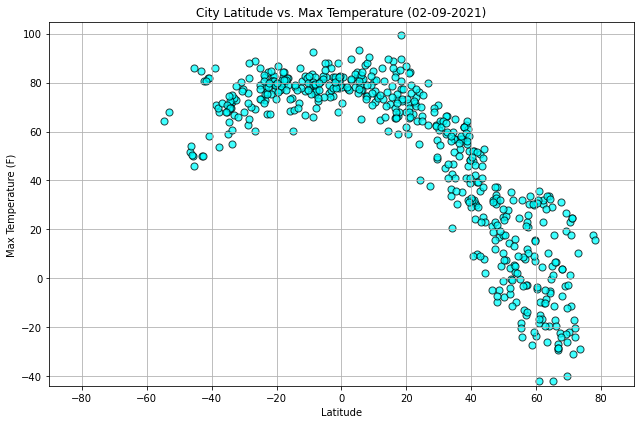

In [3]:
# Make a scatter plot to show relationship of temperature v latitude

x = weather_df["Latitude"]
y = weather_df["Max Temperature (F)"]
date = weather_df["Date"][0]
ymax = max(y)
ymin = min(y)

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(1.05*ymin, 1.05*ymax)
plt.title(f"City Latitude vs. Max Temperature ({date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid()
plt.tight_layout()

# Save plot as a PNG file
plt.savefig("temp_plot.png")

plt.show()

This plot shows the relationship between the latitude coordinate of each city in the list versus its daily maximum temperature. It shows a clear hint of a bell-shaped curve, although there is a distinct lack of data for the Southern hemisphere. This suggests that temperature is reasonably normally distributed across the globe, with the highs nearest the equator and the lows closer to the poles.

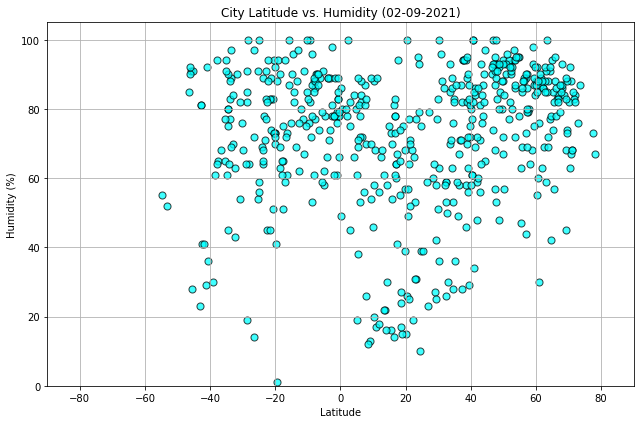

In [4]:
# Make a scatter plot to show the relationship of humidity v latitude

x = weather_df["Latitude"]
y = weather_df["Humidity (%)"]
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(0, 105)
plt.title(f"City Latitude vs. Humidity ({date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
plt.tight_layout()

# Save plot as a PNG file
plt.savefig("humid_plot.png")

plt.show()

This plot shows the relationship between the latitude coordinate of each city and its relative humidity. It shows that most of the cities in our dataset have a humidity of 50% or higher, and that humidity does not seem to be strongly correlated to latitude or temperature.

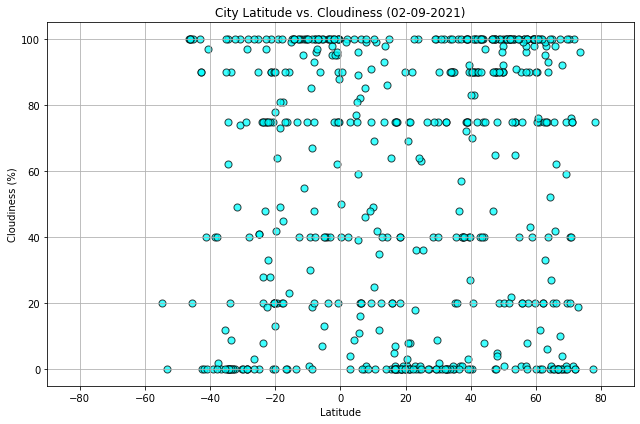

In [5]:
# Make a scatter plot to show the relationship of cloudiness v latitude

x = weather_df["Latitude"]
y = weather_df["Cloudiness"]
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(-5, 105)
plt.title(f"City Latitude vs. Cloudiness ({date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid()
plt.tight_layout()

# Save plot as a PNG file
plt.savefig("cloud_plot.png")

plt.show()

This plot shows the relationship between the latitude of each city and its percentage of cloud cover. There are strong lines of measurements at the 0, 20, 40, 75, and 100 percent marks. I interpret these as being based on human estimates, rather than quantifiable data.

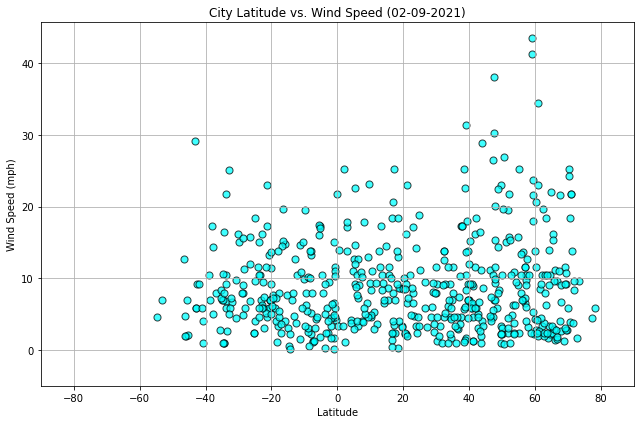

In [6]:
# Make a scatter plot to show the relationship of wind speed v latitude

x = weather_df["Latitude"]
y = weather_df["Wind Speed (mph)"]
ymax = max(y)
date = weather_df["Date"][0]

plt.figure(figsize=(9,6))
plt.scatter(x, y, marker="o", s=50, facecolor="cyan", edgecolors="black", alpha=0.75, linewidths=1)
plt.xlim(-90,90)
plt.ylim(-5, 1.05*ymax)
plt.title(f"City Latitude vs. Wind Speed ({date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid()
plt.tight_layout()

# Save plot as a PNG file
plt.savefig("wind_plot.png")

plt.show()

This plot shows the relationship between the latitude of the cities and their wind speed. Most cities have wind speeds less than 20 mph, and there does not seem to be much correlation between latitude and wind speed.

## Perform linear regressions to draw conclusions about the data:

In [23]:
# Create bins and bin data by hemisphere

bins = [-90, 0, 90]
labels = ["south", "north"]
weather_df["Hemisphere"] = pd.cut(weather_df["Latitude"], bins=bins, labels=labels)
weather_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Vuktyl,RU,63.86,57.31,-19.3,88,93,1.6,02-09-2021,north
1,Busselton,AU,-33.65,115.33,55.0,97,90,6.8,02-09-2021,south
2,Provideniya,RU,64.38,-173.30,-5.3,77,0,13.9,02-09-2021,north
3,Boyolangu,ID,-8.12,111.89,75.5,88,93,2.2,02-09-2021,south
4,Honiara,SB,-9.43,159.95,78.6,82,30,6.2,02-09-2021,south


In [24]:
# Split data into two frames, one for each hemisphere

weather_north_df = weather_df.loc[weather_df["Latitude"] > 0]
weather_north_df.reset_index(inplace=True, drop=True)
weather_north_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Vuktyl,RU,63.86,57.31,-19.3,88,93,1.6,02-09-2021,north
1,Provideniya,RU,64.38,-173.30,-5.3,77,0,13.9,02-09-2021,north
2,Hilo,US,19.73,-155.09,68.0,68,90,3.4,02-09-2021,north
3,Tamiahua,MX,21.27,-97.45,79.1,71,8,6.5,02-09-2021,north
4,Cabo San Lucas,MX,22.89,-109.91,74.0,53,1,8.0,02-09-2021,north


In [46]:
# Same for southern hemisphere

weather_south_df = weather_df.loc[weather_df["Hemisphere"] == "south"]
weather_south_df.reset_index(inplace=True, drop=True)
weather_south_df.head()

,Cities,Countries,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Date,Hemisphere
0,Busselton,AU,-33.65,115.33,55.0,97,90,6.8,02-09-2021,south
1,Boyolangu,ID,-8.12,111.89,75.5,88,93,2.2,02-09-2021,south
2,Honiara,SB,-9.43,159.95,78.6,82,30,6.2,02-09-2021,south
3,Rikitea,PF,-23.12,-134.97,78.4,71,48,6.9,02-09-2021,south
4,Charters Towers,AU,-20.10,146.27,73.4,92,78,11.4,02-09-2021,south


In [26]:
# Northern Hemisphere - Temperature (F) vs. Latitude
# Southern Hemisphere - Temperature (F) vs. Latitude

# define values for northern hemisphere
xn = weather_north_df["Latitude"]
yn = weather_north_df["Max Temperature (F)"]

#calculate regression
(slope_n, intercept_n, rvalue_n, pvalue_n, stderr_n) = linregress(xn, yn)
regress_n = xn * slope_n + intercept_n
line_eq_n = "y=" + str(round(slope_n,2)) + "x + " + str(round(intercept_n,2))
print(line_eq_n)

y=-1.5x + 96.63


In [27]:
#define values for southern hemisphere
xs = weather_south_df["Latitude"]
ys = weather_south_df["Max Temperature (F)"]

#calculate regression
(slope_s, intercept_s, rvalue_s, pvalue_s, stderr_s) = linregress(xs, ys)
regress_s = xs * slope_s + intercept_s
line_eq_s = "y=" + str(round(slope_s,2)) + "x + " + str(round(intercept_s,2))
print(line_eq_s)

y=0.33x + 82.34


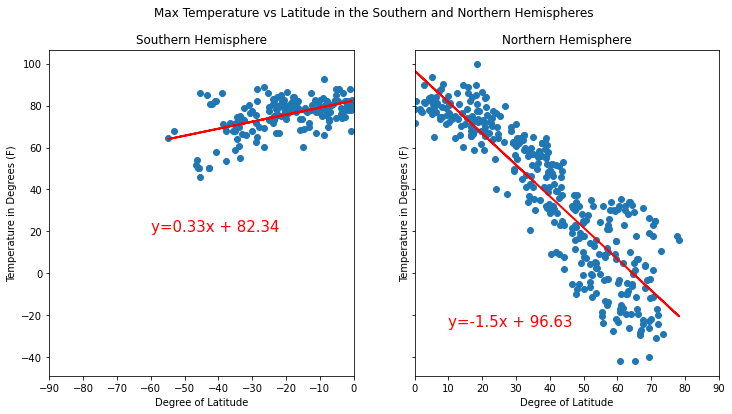

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Max Temperature vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Temperature in Degrees (F)")
ax1.plot(xs, regress_s, color='red', linewidth=2)
ax1.annotate(line_eq_s, (-60,20), fontsize=15, color="red")
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Temperature in Degrees (F)")
ax2.plot(xn, regress_n, color="red", linewidth=2)
ax2.annotate(line_eq_n, (10,-25), fontsize=15, color="red")
plt.show()

In [29]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s,5)} and the r-value of the northern hemisphere is {round(rvalue_n,5)}.')

The r-value of the southern hemisphere is 0.52306 and the r-value of the northern hemisphere is -0.88661.


This pair of plots shows the linear regression of the comparison between latitude and temperature for each hemisphere. It shows a medium but significant positive correlation in the southern hemisphere, and a strong negative correlation in the northern hemisphere. This indicates that there is a good probability that temperature is related to Earth's latitude.

In [30]:
# Northern Hemisphere - Humidity (%) vs. Latitude
# Southern Hemisphere - Humidity (%) vs. Latitude

xn2 = weather_north_df["Latitude"]
yn2 = weather_north_df["Humidity (%)"].astype(int)

#calculate regression
(slope_n2, intercept_n2, rvalue_n2, pvalue_n2, stderr_n2) = linregress(xn2, yn2)
regress_n2 = xn2 * slope_n2 + intercept_n2
line_eq_n2 = "y=" + str(round(slope_n2,2)) + "x + " + str(round(intercept_n2,2))
print(line_eq_n2)

y=0.42x + 54.9


In [31]:
xs2 = weather_south_df["Latitude"]
ys2 = weather_south_df["Humidity (%)"].astype(int)

#calculate regression
(slope_s2, intercept_s2, rvalue_s2, pvalue_s2, stderr_s2) = linregress(xs2, ys2)
regress_s2 = xs2 * slope_s2 + intercept_s2
line_eq_s2 = "y=" + str(round(slope_s2,2)) + "x + " + str(round(intercept_s2,2))
print(line_eq_s2)

y=0.33x + 81.42


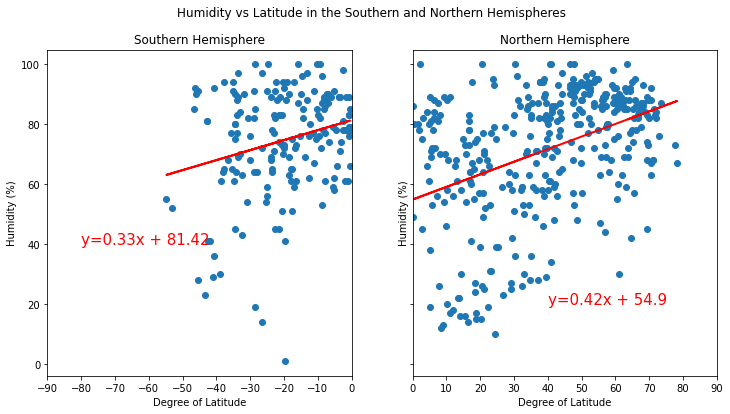

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Humidity vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs2, ys2)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Humidity (%)")
ax1.plot(xs2, regress_s2, color='red', linewidth=2)
ax1.annotate(line_eq_s2, (-80,40), fontsize=15, color="red")
ax2.scatter(xn2, yn2)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Humidity (%)")
ax2.plot(xn2, regress_n2, color="red", linewidth=2)
ax2.annotate(line_eq_n2, (40,20), fontsize=15, color="red")
plt.show()

In [33]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s2,5)} and the r-value of the northern hemisphere is {round(rvalue_n2,5)}.')

The r-value of the southern hemisphere is 0.24887 and the r-value of the northern hemisphere is 0.40233.


This pair of plots shows the linear regression of the comparison between latitude and humidity for each hemisphere. Both hemispheres show a reasonably low correlation, although the northern hemisphere is somewhat higher than the southern hemisphere. It might be interesting to further examine the data from the northern hemisphere, as there seems to be a greater variation in humidity toward the equator that tends toward a smaller and more concentrated subset as latitude increases.

In [34]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude
# Southern Hemisphere - Cloudiness (%) vs. Latitude

# define values for northern hemisphere
xn3 = weather_north_df["Latitude"]
yn3 = weather_north_df["Cloudiness"].astype(int)

#calculate regression
(slope_n3, intercept_n3, rvalue_n3, pvalue_n3, stderr_n3) = linregress(xn3, yn3)
regress_n3 = xn3 * slope_n3 + intercept_n3
line_eq_n3 = "y=" + str(round(slope_n3,2)) + "x + " + str(round(intercept_n3,2))
print(line_eq_n3)

y=0.27x + 43.01


In [35]:
#define values for southern hemisphere
xs3 = weather_south_df["Latitude"]
ys3 = weather_south_df["Cloudiness"].astype(int)

#calculate regression
(slope_s3, intercept_s3, rvalue_s3, pvalue_s3, stderr_s3) = linregress(xs3, ys3)
regress_s3 = xs3 * slope_s3 + intercept_s3
line_eq_s3 = "y=" + str(round(slope_s3,2)) + "x + " + str(round(intercept_s3,2))
print(line_eq_s3)

y=0.96x + 77.5


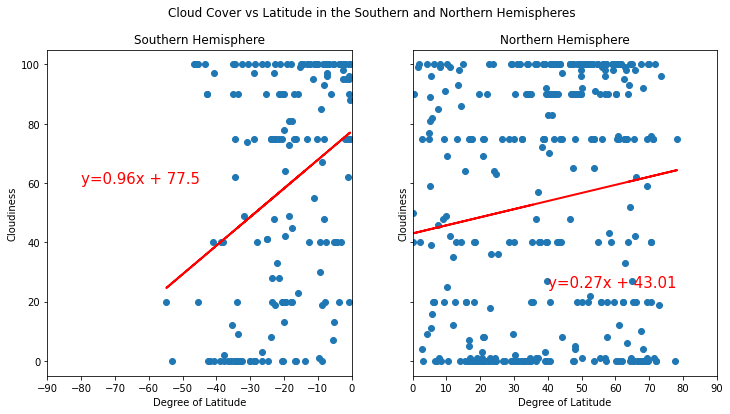

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Cloud Cover vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs3, ys3)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel= "Degree of Latitude", ylabel="Cloudiness")
ax1.plot(xs3, regress_s3, color='red', linewidth=2)
ax1.annotate(line_eq_s3, (-80,60), fontsize=15, color="red")
ax2.scatter(xn3, yn3)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Cloudiness")
ax2.plot(xn3, regress_n3, color="red", linewidth=2)
ax2.annotate(line_eq_n3, (40,25), fontsize=15, color="red")
plt.show()

In [ ]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s3,5)} and the r-value of the northern hemisphere is {round(rvalue_n3,5)}.')

This pair of plots shows the linear regression of the comparison between latitude and cloud cover for each hemisphere. These lines show a very weak correlation between the two data points. Given the uncertain nature of the cloudiness data and how it is derived, I would be very hesitent to try to draw conclusions from this model.

In [38]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude
# Southern Hemisphere - Wind Speed (mph) vs. Latitude

# define values for northern hemisphere
xn4 = weather_north_df["Latitude"]
yn4 = weather_north_df["Wind Speed (mph)"]

#calculate regression
(slope_n4, intercept_n4, rvalue_n4, pvalue_n4, stderr_n4) = linregress(xn4, yn4)
regress_n4 = xn4 * slope_n4 + intercept_n4
line_eq_n4 = "y=" + str(round(slope_n4,2)) + "x + " + str(round(intercept_n4,2))
print(line_eq_n4)

y=0.02x + 8.56


In [43]:
#define values for southern hemisphere
xs4 = weather_south_df["Latitude"]
ys4 = weather_south_df["Wind Speed (mph)"]

#calculate regression
(slope_s4, intercept_s4, rvalue_s4, pvalue_s4, stderr_s4) = linregress(xs4, ys4)
regress_s4 = xs4 * slope_s4 + intercept_s4
line_eq_s4 = "y=" + str(round(slope_s4,2)) + "x + " + str(round(intercept_s4,2))
print(line_eq_s4)

y=-0.04x + 7.13


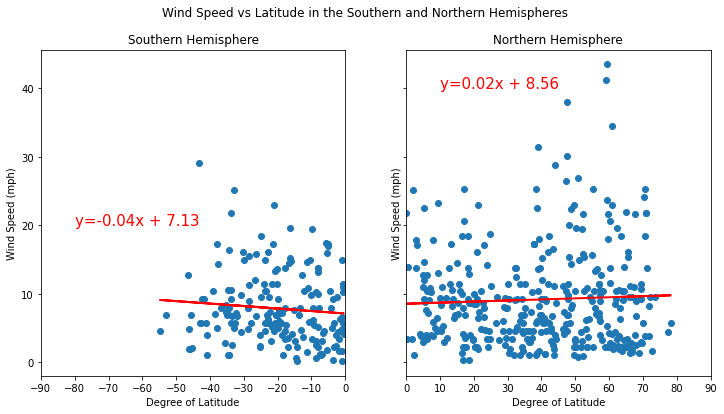

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('Wind Speed vs Latitude in the Southern and Northern Hemispheres')
ax1.scatter(xs4, ys4)
ax1.set_xlim(left=-90, right=0)
ax1.set_title("Southern Hemisphere")
ax1.set(xlabel="Degree of Latitude", ylabel="Wind Speed (mph)")
ax1.plot(xs4, regress_s4, color='red', linewidth=2)
ax1.annotate(line_eq_s4, (-80,20), fontsize=15, color="red")
ax2.scatter(xn4, yn4)
ax2.set_xlim(left=0, right=90)
ax2.set_title("Northern Hemisphere")
ax2.set(xlabel= "Degree of Latitude", ylabel="Wind Speed (mph)")
ax2.plot(xn4, regress_n4, color="red", linewidth=2)
ax2.annotate(line_eq_n4, (10,40), fontsize=15, color="red")
plt.show()

In [45]:
print(f'The r-value of the southern hemisphere is {round(rvalue_s4,5)} and the r-value of the northern hemisphere is {round(rvalue_n4,5)}.')

The r-value of the southern hemisphere is -0.09069 and the r-value of the northern hemisphere is 0.045.


This pair of plots shows the linear regression of the comparison between latitude and wind speed for each hemisphere. The correlation here is extremely weak, and demonstrates that wind speed does not appear to have a meaningful connection to latitude.